# 🧪 NMR Deep Learning Enhancement Project 🚀

## ✅ Goals & To-Dos

1. **Prepare FID Data** 📊  
   - Load raw FID using `nmr.load_fid_and_preview`  
   - Normalize and format for PyTorch `(batch, 1, length)`  

2. **Build DL Model** 🤖  
   - 1D Convolutional Autoencoder or Dilated Conv Network  
   - Input: raw FID  
   - Output: enhanced / denoised FID  

3. **Train Model** 🏋️‍♂️  
   - Start with **simulated FIDs** (damped sinusoids + noise)  
   - Later fine-tune on **experimental FIDs**  

4. **Integrate With Existing Pipeline** 🔗  
   - Feed `enhanced_FID` into `compute_fft_spectrum`  
   - Run peak detection, integration, and J-coupling analysis as usual  

5. **Compare Results** 📈  
   - Original vs enhanced FID → FFT → peaks → integrals  
   - Evaluate **noise reduction, peak clarity, and acquisition efficiency**  

6. **Optional Advanced Steps** ✨  
   - End-to-end model: partial FID → predicted spectrum  
   - Explore **super-resolution/extrapolation** to reduce acquisition time  

---

💡 **Tip:** Keep the DL module modular so it can be swapped in/out without breaking existing code.  

| Goal                   | What to Do                                                    |
| ---------------------- | ------------------------------------------------------------- |
| Prevent over-smoothing | Add L1 term to loss; raise frequency weight                   |
| Match real stats       | Add correlated complex noise + polynomial baselines           |
| Teach confidence       | Replace last Conv1d with BayesianTorch layer                  |
| Fine-tune realism      | Convert 10–20 real FIDs → `.asc` → arrays → 1–3 epochs low-LR |
| Quantify success       | Track ΔSNR, FFT correlation, and residual histograms          |


In [ ]:
# Imports + optional checkpoint loader
import math, time, os, glob, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
import functions.nmr_function as nmr
from importlib import reload

# Optional: auto-load latest checkpoint if present
CHECKPOINT_DIR = os.path.join(os.getcwd(), "checkpoints")
LATEST = os.path.join(CHECKPOINT_DIR, "DenoiseNetPhysics_latest.pth")
if os.path.exists(LATEST):
    try:
        print("Found existing checkpoint. It will be loaded after model is instantiated.")
    except Exception:
        pass

In [ ]:
# Combined loader + batch for-loop over training_data with preview heads and metrics
import os, glob, math, numpy as np, torch, matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
from importlib import reload
import functions.nmr_function as nmr
from functions import nmr_function as nf

# --- Config ---
data_dir = r"C:\Users\Windows User\NMR-Project\training_data"
save_outputs = False  # set True to write denoised .asc files
out_dir = os.path.join(data_dir, "denoised")
max_preview = 5  # only show heads/plots for first N files
if save_outputs:
    os.makedirs(out_dir, exist_ok=True)

# --- Model availability ---
_using_identity = False
if 'model_physics' not in globals():
    print("[Info] model_physics is not defined yet. Using identity pass-through for preview only.\n"
          "Run the training cells to replace this with your trained model.")
    class _Identity(nn.Module):
        def forward(self, x):
            return x
    model_physics = _Identity()
    _using_identity = True

def _model_device(mp):
    try:
        p = next(mp.parameters())
        return p.device
    except Exception:
        return torch.device('cpu')

device = _model_device(model_physics)

# --- Helpers (shared with training) ---
def _read_asc(path):
    """Read an .asc file robustly. Returns cleaned (time, real, imag)."""
    arr = np.genfromtxt(path, delimiter=None)
    if arr is None or arr.size == 0:
        raise ValueError(f"Empty data in {path}")
    if arr.ndim == 1:
        arr = arr.reshape(-1, 1)
    if arr.shape[1] == 1:
        r = arr[:, 0].astype(float)
        im = np.zeros_like(r)
        t = np.arange(len(r), dtype=float)
    else:
        t = arr[:, 0].astype(float)
        r = arr[:, 1].astype(float)
        im = (arr[:, 2].astype(float) if arr.shape[1] >= 3 else np.zeros_like(r))
    # Drop non-finite rows and sort by time if descending
    m = np.isfinite(t) & np.isfinite(r) & np.isfinite(im)
    t, r, im = t[m], r[m], im[m]
    if t.size >= 2 and t[1] < t[0]:
        idx = np.argsort(t)
        t, r, im = t[idx], r[idx], im[idx]
    return t, r, im

def _preprocess_pair(real_imag_2xL: np.ndarray) -> np.ndarray:
    """Baseline remove using last 20% and scale by tail RMS (shape (2, L))."""
    sig = real_imag_2xL.copy()
    L = sig.shape[1]
    tail = slice(int(0.8 * L), L)
    baseline = sig[:, tail].mean(axis=1, keepdims=True)
    sig -= baseline
    tail_rms = np.sqrt((sig[:, tail] ** 2).mean(axis=1, keepdims=True) + 1e-12)
    sig /= (tail_rms + 1e-12)
    return sig

def _denoise(sig_2xL: np.ndarray) -> np.ndarray:
    mp = model_physics
    dv = _model_device(mp)
    mp.eval()
    with torch.no_grad():
        x = torch.from_numpy(sig_2xL).unsqueeze(0).to(dv)  # (1,2,L)
        y = mp(x).detach().cpu().squeeze(0).numpy()  # (2,L)
    return y

def _head_print(time_s: np.ndarray, real: np.ndarray, imag: np.ndarray, rows: int = 8, label: str = None):
    n = min(rows, time_s.shape[0])
    df = pd.DataFrame({"time_s": time_s[:n], "real": real[:n], "imag": imag[:n]})
    if label:
        print(f"\n{label}")
    print(df.to_string(index=False))

def _snr_from_env(env: np.ndarray) -> float:
    L = env.shape[0]
    s0, s1 = 0, max(1, int(0.2 * L))
    n0, n1 = int(0.8 * L), L
    sig_rms = float(np.sqrt(np.mean(env[s0:s1]**2)))
    noise_rms = float(np.sqrt(np.mean(env[n0:n1]**2)))
    return 20 * np.log10(sig_rms / (noise_rms + 1e-12))

# --- Collect files & quick single-file preview ---
files = sorted(glob.glob(os.path.join(data_dir, "*.asc")))
if not files:
    raise FileNotFoundError(f"No .asc files found in {data_dir}")
print(f"Found {len(files)} .asc files in {data_dir}")
if _using_identity:
    print("Note: Using identity model. ΔSNR should be ~0; this is for quick visual checks only.\n")

# Preview head for the first file so the for-loop context is obvious
t0, r0, im0 = _read_asc(files[0])
_head_print(t0, r0, im0, rows=8, label=f"First file head → {os.path.basename(files[0])}")

# --- Main for-loop over all files (visible) ---
previewed = 0
processed = 0
saved = 0
improved = 0
for idx, fpath in enumerate(files, start=1):
    fname = os.path.basename(fpath)
    try:
        t, r, im = _read_asc(fpath)
        # Ensure consistent orientation (2, L)
        pair = np.stack([r, im])  # (2, L)
        # Preprocess and denoise
        sig = _preprocess_pair(pair)
        den = _denoise(sig)
        # Metrics
        env_x = np.sqrt(sig[0]**2 + sig[1]**2)
        env_y = np.sqrt(den[0]**2 + den[1]**2)
        mse = float(np.mean((den - sig)**2))
        snr_x = _snr_from_env(env_x)
        snr_y = _snr_from_env(env_y)
        dsnr = snr_y - snr_x
        if dsnr > 0.5:
            improved += 1
        # For first few, show head, metrics, and a compact plot
        if previewed < max_preview:
            _head_print(t, r, im, rows=8, label=f"Head for {fname}")
            print(f"Metrics → MSE={mse:.3e} | SNR orig={snr_x:.2f} dB | den={snr_y:.2f} dB | Δ={dsnr:.2f} dB")
            plt.figure(figsize=(9, 3))
            early = min(2000, sig.shape[1])
            tt_idx = np.arange(early)  # robust index-based x-axis
            plt.plot(tt_idx, sig[0, :early], label='orig real (scaled)', alpha=0.6)
            plt.plot(tt_idx, den[0, :early], label='denoised real', lw=1.2)
            plt.title(f"Early-time (real): {fname}")
            plt.xlabel("Index")
            plt.legend()
            plt.tight_layout()
            plt.show()
            previewed += 1
        # Optionally save denoised (time, real, imag)
        if save_outputs:
            out_path = os.path.join(out_dir, os.path.splitext(fname)[0] + "_denoised.asc")
            to_save = np.column_stack([t, den[0], den[1]])
            np.savetxt(out_path, to_save, fmt="%.9g", header="time_s real imag", comments="")
            saved += 1
        processed += 1
    except Exception as e:
        print(f"[Skip] {fname}: {e}")
        continue

summary = f"Processed: {processed} files | Previewed: {previewed} | Improved ΔSNR>0.5 dB: {improved}"
if save_outputs:
    summary += f" | Saved: {saved} → {out_dir}"
print("\n" + summary)

In [7]:
# ---- 0) Device + AMP ----
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
try:
    torch.set_float32_matmul_precision('high')
except Exception:
    pass
if use_cuda:
    torch.backends.cudnn.benchmark = True
    from torch.cuda.amp import autocast, GradScaler
    scaler = GradScaler(enabled=True)
else:
    from contextlib import nullcontext
    autocast = lambda enabled=False: nullcontext()
    class _Noop:
        def scale(self, x): return x
        def step(self, opt): opt.step()
        def update(self): pass
    scaler = _Noop()


In [ ]:
# Real-data preprocessing: baseline removal + tail RMS scaling (preserves noise scale)
import numpy as np, torch, os, glob

# Ensure device exists (fallback cpu if this cell is run before device cell)
try:
    device
except NameError:
    device = torch.device('cpu')

# Ensure we have a `data`/`pair` to build `sig`; if not, read the first file from data_dir using shared _read_asc
if 'sig' not in globals():
    if 'pair' in globals():
        tmp_pair = pair
    elif 'data' in globals():
        arr = np.asarray(data)
        if arr.ndim == 2 and arr.shape[1] >= 2:
            r = arr[:, 1].astype(float)
            im = arr[:, 2].astype(float) if arr.shape[1] >= 3 else np.zeros_like(r)
            tmp_pair = np.stack([r, im])
        else:
            raise ValueError("`data` is not shaped like (N,>=2). Can't construct [real, imag].")
    else:
        # Fallback: read first .asc using utilities defined in the combined loader cell
        if 'data_dir' in globals() and '_read_asc' in globals():
            files_fallback = sorted(glob.glob(os.path.join(data_dir, "*.asc")))
            if not files_fallback:
                raise FileNotFoundError(f"No .asc files found in {data_dir}")
            t_fb, r_fb, im_fb = _read_asc(files_fallback[0])
            data = np.column_stack([t_fb, r_fb, im_fb])
            tmp_pair = np.stack([r_fb, im_fb])
            # derive dt from fallback
            if 'dt' not in globals():
                dt = float(t_fb[1] - t_fb[0]) if t_fb.size >= 2 else 1.0
        else:
            raise NameError("No `data` present and loader utilities unavailable. Run the combined loader cell first.")
    L = tmp_pair.shape[1]
    tail = slice(int(0.8 * L), L)
    baseline = tmp_pair[:, tail].mean(axis=1, keepdims=True)
    sig = tmp_pair - baseline
    tail_rms = np.sqrt((sig[:, tail] ** 2).mean(axis=1, keepdims=True) + 1e-12)
    sig = sig / (tail_rms + 1e-12)
else:
    L = sig.shape[1]

# Build torch tensor on the chosen device (float32)
fid_tensor = torch.from_numpy(sig).float().unsqueeze(0).to(device)  # (1,2,L)

# ---- 2) Physics params + T2 estimate prerequisites ----
if 'dt' not in globals():
    # derive from `data` if possible
    if 'data' in globals() and np.asarray(data).shape[0] >= 2:
        dt = float(data[1, 0] - data[0, 0])
    else:
        dt = 1.0

gamma_Hz_per_T = 42.57747892e6       # 1H gyromagnetic ratio (Hz/T)

# Set spectrometer frequency directly (Hz)
nu0_Hz = 399.78219838e6              # 399.78219838 MHz
nu0_MHz = nu0_Hz / 1e6

nyquist_hz = 1.0 / (2.0 * dt)
nyquist_ppm = nyquist_hz / nu0_MHz

In [9]:
@torch.no_grad()
def _estimate_t2(fid_1x2xL: torch.Tensor, dt: float, frac: float = 0.25) -> float:
    r = fid_1x2xL[0, 0]
    i = fid_1x2xL[0, 1]
    env = torch.clamp(torch.sqrt(r * r + i * i), min=1e-12)
    n = max(16, int(frac * env.shape[-1]))
    t = torch.arange(n, device=env.device, dtype=env.dtype) * dt
    y = torch.log(env[:n])
    A = torch.stack([torch.ones_like(t), t], dim=1)  # [n,2]
    sol = torch.linalg.lstsq(A, y.unsqueeze(1)).solution  # [2,1]
    b = float(sol[1])
    T2 = (-1.0 / b) if b < 0 else (0.2 * n * dt)
    return float(max(T2, 1e-6))

T2_est = _estimate_t2(fid_tensor.float(), dt)
print(f"dt={dt:.6g}s | ν0={nu0_MHz:.3f} MHz | Nyquist≈{nyquist_ppm:.2f} ppm | T2_est≈{T2_est:.3f}s")

# ---- 3) Physics-aware synthetic generator (match real preprocessing; add optional colored noise) ----
def synth_batch_phys(batch_size=8, L=2048, dt=dt, nu0_MHz=nu0_MHz,
                     nyquist_ppm=nyquist_ppm, n_comp_min=2, n_comp_max=6,
                     T2_range=(0.5 * T2_est, 1.5 * T2_est), snr_std=0.03,
                     colored_noise=True, device=device):
    t = torch.arange(L, device=device) * dt
    clean = torch.zeros(batch_size, 2, L, device=device)

    ppm_lo = 0.15
    ppm_hi = max(ppm_lo * 1.2, nyquist_ppm * 0.9)  # keep within SW

    for b in range(batch_size):
        n_comp = torch.randint(n_comp_min, n_comp_max + 1, (1,), device=device).item()
        sig_r = torch.zeros(L, device=device)
        sig_i = torch.zeros(L, device=device)
        for _ in range(n_comp):
            A = 0.5 + 0.8 * torch.rand((), device=device)
            ppm = ppm_lo + (ppm_hi - ppm_lo) * torch.rand((), device=device)
            f_hz = ppm * nu0_MHz
            phi = 2 * math.pi * torch.rand((), device=device)
            T2c_low, T2c_high = T2_range
            T2c_low = float(max(1e-3, T2c_low))
            T2c_high = float(max(1e-3, T2c_high))
            if T2c_high < T2c_low:
                T2c_low, T2c_high = T2c_high, T2c_low
            T2c = T2c_low + (T2c_high - T2c_low) * torch.rand((), device=device)
            env = torch.exp(-t / T2c)
            arg = 2 * math.pi * f_hz * t + phi
            sig_r += A * env * torch.cos(arg)
            sig_i += A * env * torch.sin(arg)
        # Match real-data preprocessing (baseline + tail RMS scaling)
        tail = slice(int(0.8 * L), L)
        base_r = sig_r[tail].mean(); base_i = sig_i[tail].mean()
        sig_r = sig_r - base_r; sig_i = sig_i - base_i
        tail_rms = torch.sqrt((sig_r[tail] ** 2).mean() + (sig_i[tail] ** 2).mean() + 1e-12)
        sig_r = sig_r / (tail_rms + 1e-8)
        sig_i = sig_i / (tail_rms + 1e-8)
        # Small linear drift
        drift = 0.003 * torch.linspace(0, 1, L, device=device)
        sig_r = sig_r + drift
        clean[b, 0] = sig_r
        clean[b, 1] = sig_i

    # White noise
    noise = snr_std * torch.randn_like(clean)

    # Optional colored noise (1/f shaping)
    if colored_noise:
        H = torch.fft.rfft(torch.randn(batch_size, 2, L, device=device), dim=-1)
        freqs = torch.fft.rfftfreq(L, d=dt, device=device)
        shaping = 1.0 / (freqs.clamp_min(1.0))  # avoid inf at DC
        H = H * shaping.view(1, 1, -1)
        col = torch.fft.irfft(H, n=L, dim=-1)
        col = col / (col.std(dim=-1, keepdim=True) + 1e-8) * snr_std
        noise = 0.5 * noise + 0.5 * col

    noisy = clean + noise
    return noisy, clean

# ---- 4) Combined loss (normalized freq magnitude + envelope-to-target) ----
def _to_complex(x):  # x: (B,2,L)
    return torch.complex(x[:, 0], x[:, 1])

def _freq_mag_norm_c(zc):  # zc: (B,L) complex
    Z = torch.fft.fft(zc, dim=-1)
    # keep non-negative frequencies like rfft
    pos_len = zc.shape[-1] // 2 + 1
    Zpos = Z[..., :pos_len]
    mag = torch.abs(Zpos)
    mag = mag / (mag.amax(dim=-1, keepdim=True) + 1e-8)
    return mag

def _env_norm(x):  # x: (B,2,L)
    e = torch.sqrt(x[:, 0] ** 2 + x[:, 1] ** 2)
    n0 = max(8, int(0.02 * e.shape[-1]))
    s = e[:, :n0].mean(dim=-1, keepdim=True) + 1e-8
    return e / s

def combined_loss(pred, target, dt=dt, w_time=0.6, w_freq=0.35, w_env=0.05):
    # Time-domain MSE
    lt = torch.mean((pred - target) ** 2)
    # Frequency magnitude loss (phase-invariant, per-sample normalized)
    lf = torch.mean((_freq_mag_norm_c(_to_complex(pred)) - _freq_mag_norm_c(_to_complex(target))) ** 2)
    # Envelope matching to target (scale-normalized by early-time mean)
    le = torch.mean((_env_norm(pred) - _env_norm(target)) ** 2)
    return w_time * lt + w_freq * lf + w_env * le

# ---- 5) Model definition ----
class DilatedResBlock(nn.Module):
    def __init__(self, channels, dilation=1, k=11):
        super().__init__()
        pad = dilation * ((k - 1) // 2)
        self.conv1 = nn.Conv1d(channels, channels, k, padding=pad, dilation=dilation)
        self.conv2 = nn.Conv1d(channels, channels, k, padding=pad, dilation=dilation)
    def forward(self, x):
        h = F.relu(self.conv1(x))
        h = self.conv2(h)
        return F.relu(x + h)

class DenoiseNetPhysics(nn.Module):
    def __init__(self, in_ch=2, hidden=64, k=11, dilations=(1, 2, 4, 8, 16, 32)):
        super().__init__()
        self.inp = nn.Conv1d(in_ch, hidden, k, padding=(k - 1) // 2)
        self.blocks = nn.Sequential(*[DilatedResBlock(hidden, d, k) for d in dilations])
        self.out = nn.Conv1d(hidden, in_ch, k, padding=(k - 1) // 2)  # residual
    def forward(self, x):
        h = F.relu(self.inp(x))
        h = self.blocks(h)
        resid = self.out(h)
        return x + resid

def _init_weights(m):
    if isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

dt=0.00013328s | ν0=399.782 MHz | Nyquist≈9.38 ppm | T2_est≈3.849s


In [ ]:
# Model instantiation + training hyperparameters + checkpoint config
import os, time, math, torch
from datetime import datetime

MODEL_NAME = "DenoiseNetPhysics"
CHECKPOINT_DIR = os.path.join(os.getcwd(), "checkpoints")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

model_physics = DenoiseNetPhysics().apply(_init_weights).to(device)
opt = torch.optim.Adam(model_physics.parameters(), lr=8e-4, weight_decay=1e-4)

# Optionally load latest checkpoint if present
latest_path = os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_latest.pth")
if os.path.exists(latest_path):
    try:
        state = torch.load(latest_path, map_location=device)
        model_physics.load_state_dict(state['model_state'])
        print(f"Loaded checkpoint: {latest_path}")
    except Exception as e:
        print("Could not load checkpoint:", e)

# ---- 6) Curriculum training with combined_loss ----
EPOCHS = 6                 # increased epochs
STEPS_PER_EPOCH = 40
BATCH_SIZE = 8
CROP_LEN = 2048
NOISE_SCHEDULE = [0.04, 0.035, 0.03, 0.03, 0.025, 0.025]  # per-epoch noise (post tail-RMS scale)

# Real-data fine-tune on all .asc files (self-denoising)
REAL_FINETUNE_EPOCHS = 1   # set >=1 to use all training_data
REAL_BATCH_SIZE = 8


Training with combined loss...
epoch 1: train_loss=0.002236 | val base=0.001701 model=0.001833 ΔSNR=-0.33 dB
epoch 1: train_loss=0.002236 | val base=0.001701 model=0.001833 ΔSNR=-0.33 dB
epoch 2: train_loss=0.001578 | val base=0.002013 model=0.002105 ΔSNR=-0.19 dB
epoch 2: train_loss=0.001578 | val base=0.002013 model=0.002105 ΔSNR=-0.19 dB
epoch 3: train_loss=0.001195 | val base=0.001547 model=0.001633 ΔSNR=-0.24 dB
train time: 134.6s

Overfitting single real FID (sanity check)...
epoch 3: train_loss=0.001195 | val base=0.001547 model=0.001633 ΔSNR=-0.24 dB
train time: 134.6s

Overfitting single real FID (sanity check)...
step 50: loss=7.367812e-08
step 50: loss=7.367812e-08
step 100: loss=1.541372e-08
step 100: loss=1.541372e-08
step 150: loss=8.369871e-09
step 150: loss=8.369871e-09
step 200: loss=5.702764e-09
step 200: loss=5.702764e-09

Shapes → input: (1, 2, 16384) denoised: (1, 2, 16384)

Shapes → input: (1, 2, 16384) denoised: (1, 2, 16384)


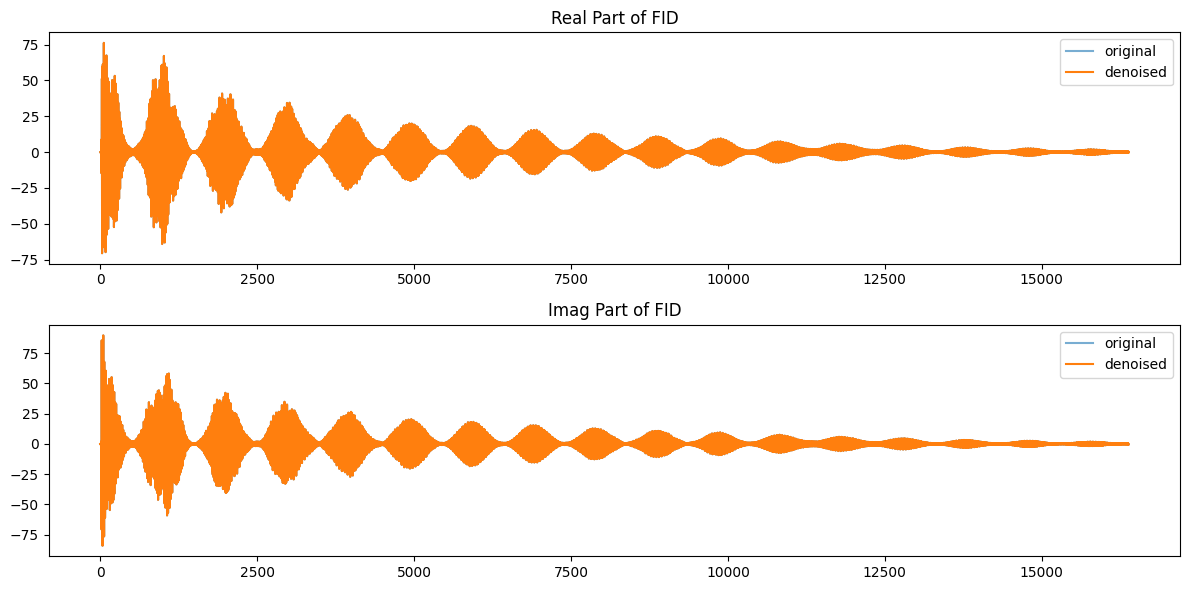

Done. This cell trained with combined_loss (normalized freq/envelope), validated ΔSNR, overfit a real FID, and plotted results.


In [ ]:
# Training: synthetic curriculum → (optional) real-data fine-tune over ALL .asc files → save checkpoints
import os, glob, numpy as np, torch, math, time
from datetime import datetime

print("\nTraining with combined loss (synthetic curriculum)...")
t0 = time.perf_counter()
for ep in range(EPOCHS):
    model_physics.train()
    running = 0.0
    sn = NOISE_SCHEDULE[min(ep, len(NOISE_SCHEDULE) - 1)]
    for _ in range(STEPS_PER_EPOCH):
        x, y = synth_batch_phys(batch_size=BATCH_SIZE, L=CROP_LEN, snr_std=sn, colored_noise=True)
        opt.zero_grad(set_to_none=True)
        with autocast(enabled=use_cuda):
            pred = model_physics(x)
            loss = combined_loss(pred, y, dt=dt)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        running += float(loss.detach())

    # Validation snapshot vs baseline at target noise
    model_physics.eval()
    with torch.no_grad():
        xv, yv = synth_batch_phys(batch_size=64, L=CROP_LEN, snr_std=NOISE_SCHEDULE[-1], colored_noise=True)
        with autocast(enabled=use_cuda):
            pv = model_physics(xv)
        mse_noisy = torch.mean((xv - yv) ** 2).item()
        mse_pred = torch.mean((pv - yv) ** 2).item()
        snr_impr_db = 20 * math.log10((mse_noisy ** 0.5) / max(mse_pred ** 0.5, 1e-12))
    print(f"epoch {ep+1}: train_loss={running/STEPS_PER_EPOCH:.6f} | val base={mse_noisy:.6f} model={mse_pred:.6f} ΔSNR={snr_impr_db:.2f} dB")

print(f"synthetic train time: {time.perf_counter()-t0:.1f}s")

# ---- Real-data fine-tune on ALL .asc files in training_data (self-denoising) ----
if REAL_FINETUNE_EPOCHS > 0:
    print("\nFine-tuning on real .asc files (self-denoising across entire training_data)...")
    files_ft = sorted(glob.glob(os.path.join(data_dir, "*.asc")))
    for ep in range(REAL_FINETUNE_EPOCHS):
        model_physics.train()
        total = 0.0; count = 0
        for f in files_ft:
            t_r, r_r, i_r = _read_asc(f)
            pair = np.stack([r_r, i_r])
            sig_np = _preprocess_pair(pair)  # (2, L)
            x_real = torch.from_numpy(sig_np).float().unsqueeze(0).to(device)
            y_real = x_real  # self-denoising target
            opt.zero_grad(set_to_none=True)
            with autocast(enabled=use_cuda):
                pred = model_physics(x_real)
                loss = combined_loss(pred, y_real, dt=dt)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            total += float(loss.detach()); count += 1
        print(f"real ft epoch {ep+1}: loss={total/max(1,count):.6f} over {count} files")

# ---- Save checkpoints ----
stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
ckpt_path = os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_{stamp}.pth")
latest_path = os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_latest.pth")
torch.save({'model_state': model_physics.state_dict(), 'config': {
    'EPOCHS': EPOCHS, 'STEPS_PER_EPOCH': STEPS_PER_EPOCH, 'BATCH_SIZE': BATCH_SIZE, 'CROP_LEN': CROP_LEN,
    'NOISE_SCHEDULE': NOISE_SCHEDULE, 'REAL_FINETUNE_EPOCHS': REAL_FINETUNE_EPOCHS
}}, ckpt_path)
torch.save({'model_state': model_physics.state_dict()}, latest_path)
print(f"Saved checkpoints → {ckpt_path} and {latest_path}")

# ---- Overfit a single real FID (sanity check) ----
print("\nOverfitting single real FID (sanity check)...")
model_physics.train()
x_real = fid_tensor.clone()  # (1,2,L)
y_real = x_real.clone()
opt_overfit = torch.optim.Adam(model_physics.parameters(), lr=1e-3)
for i in range(200):
    opt_overfit.zero_grad(set_to_none=True)
    with autocast(enabled=use_cuda):
        pred = model_physics(x_real)
        loss = combined_loss(pred, y_real, dt=dt)
    scaler.scale(loss).backward()
    scaler.step(opt_overfit)
    scaler.update()
    if (i + 1) % 50 == 0:
        print(f"step {i+1}: loss={float(loss.detach()):.6e}")

# ---- Inference on real FID + plots ----
model_physics.eval()
with torch.no_grad():
    with autocast(enabled=use_cuda):
        denoised = model_physics(fid_tensor).cpu()  # (1,2,L)

print("\nShapes → input:", tuple(fid_tensor.shape), "denoised:", tuple(denoised.shape))

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.title("Real Part of FID")
plt.plot(fid_tensor[0, 0].detach().cpu().numpy(), label="original", alpha=0.6)
plt.plot(denoised[0, 0].detach().cpu().numpy(), label="denoised", lw=1.5)
plt.legend()

plt.subplot(2, 1, 2)
plt.title("Imag Part of FID")
plt.plot(fid_tensor[0, 1].detach().cpu().numpy(), label="original", alpha=0.6)
plt.plot(denoised[0, 1].detach().cpu().numpy(), label="denoised", lw=1.5)
plt.legend()
plt.tight_layout()
plt.show()

print("Done. Trained, fine-tuned on all training_data files, saved checkpoints, overfit sanity check, and plotted results.")

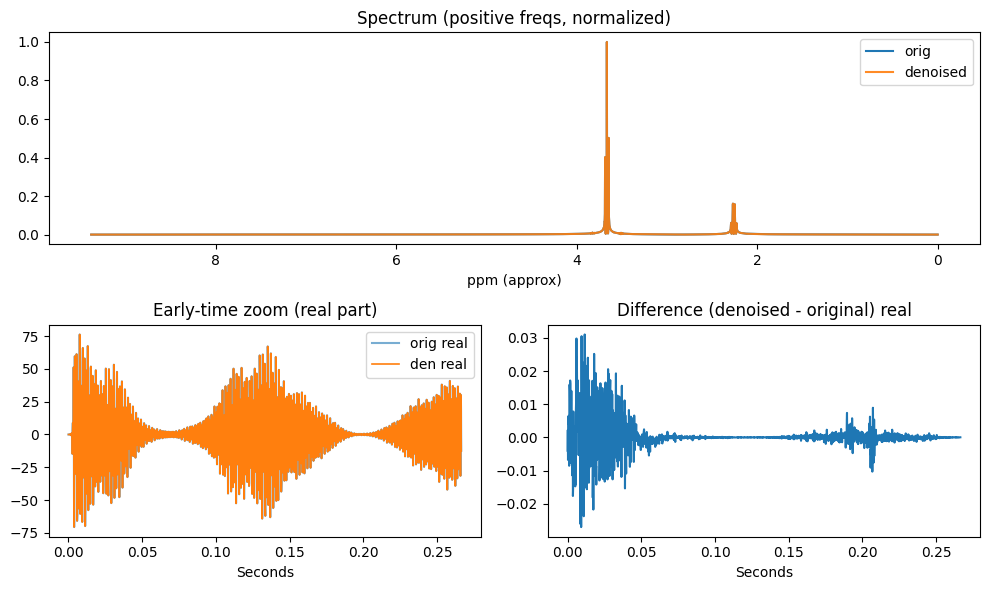

Identified functional groups:
The Peak at 2.25 ppm corresponds to a Benzylic / Next to Ar
The Peak at 2.27 ppm corresponds to a Benzylic / Next to Ar
The Peak at 3.65 ppm corresponds to a Halogen / O / N adjacent
The Peak at 3.67 ppm corresponds to a Halogen / O / N adjacent
The Peak at 3.69 ppm corresponds to a Halogen / O / N adjacent
Graph automatically zoomed to range: 2.15–3.79 ppm


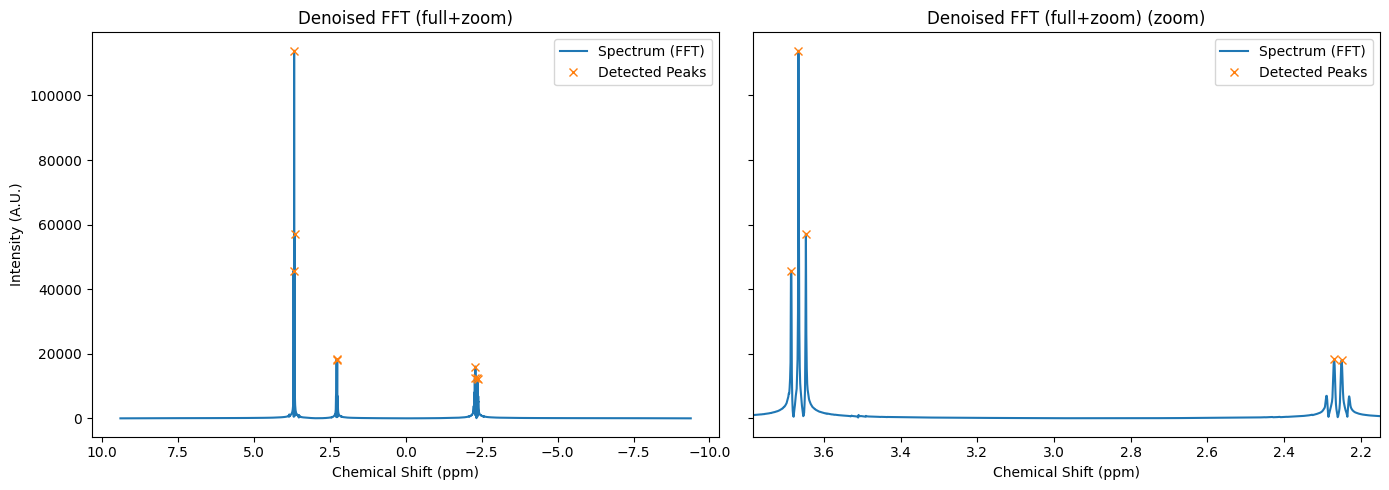

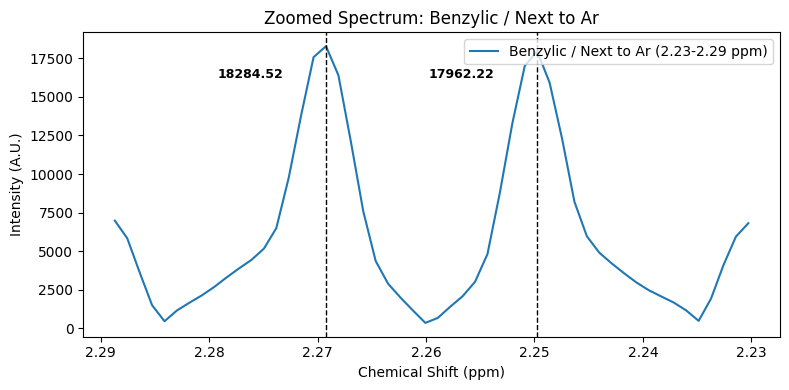

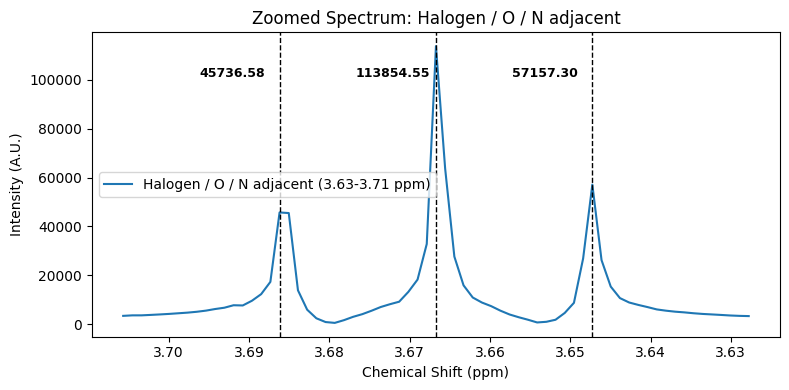


Numeric summary:
  MSE (time-domain, real+imag) = 1.988195e-06
  SNR orig = 24.265 dB | SNR den = 24.265 dB | ΔSNR = -0.000 dB

Top peak positions (ppm) — original:
[3.6667 3.6656 3.6472 3.6862 3.685 ]
Top peak positions (ppm) — denoised:
[3.6667 3.6656 3.6472 3.6862 3.685 ]
Approx peak shifts (ppm): [0. 0. 0. 0. 0.]

Recommendations:
 - Marginal change: ΔSNR within ±1 dB. To improve denoising, train on more examples or increase L1 smoothing weight slightly (e.g., 1e-5→1e-4).


In [8]:
# Unified FID analysis: MSE, SNR (dB), difference, FFT (ppm), early-time zoom, auto-zoom functional groups
import numpy as np
import torch
import matplotlib.pyplot as plt
from functions import nmr_function as nf
from functions.nmr_function import PPM_SHIFT_DEFAULTS

# Helper to coerce tensors/arrays to numpy (shape: (2, L) or (L, 2))
def to_np(a):
    if isinstance(a, torch.Tensor):
        return a.detach().cpu().squeeze(0).numpy()
    return np.asarray(a)

# Acquire data from notebook variables if present (fallback will raise informative error)
try:
    x = to_np(fid_tensor)   # expected shape (2, L) where 0=real,1=imag
    y = to_np(denoised)
    dt_local = float(dt)    # seconds per point
except NameError as e:
    raise RuntimeError(
        "Required variables not found in kernel. Ensure `fid_tensor`, `denoised`, and `dt` are defined before running this cell."
    )

# Normalize shapes: ensure shape (2, L)
if x.ndim == 1:
    raise ValueError("fid_tensor appears 1D; expected complex pair (real, imag).")
if x.shape[0] == 2 and x.shape[1] >= 1:
    pass
elif x.shape[1] == 2:
    x = x.T

if y.shape[0] != 2 and y.shape[1] == 2:
    y = y.T

L = x.shape[1]
# complex time-domain
zc = x[0] + 1j * x[1]
zd = y[0] + 1j * y[1]

# Envelope
env_x = np.sqrt(x[0]**2 + x[1]**2)
env_y = np.sqrt(y[0]**2 + y[1]**2)

# MSE (time-domain real+imag)
mse_val = float(np.mean((y - x)**2))

# SNR estimate: signal RMS from first 20%, noise from tail (last 20%)
start_sig = 0
end_sig = max(1, int(0.2 * L))
start_noise = int(0.8 * L)
end_noise = L
sig_rms_x = np.sqrt(np.mean(env_x[start_sig:end_sig]**2))
noise_rms_x = np.sqrt(np.mean(env_x[start_noise:end_noise]**2))
sig_rms_y = np.sqrt(np.mean(env_y[start_sig:end_sig]**2))
noise_rms_y = np.sqrt(np.mean(env_y[start_noise:end_noise]**2))

snr_x_db = 20 * np.log10((sig_rms_x / (noise_rms_x + 1e-12)))
snr_y_db = 20 * np.log10((sig_rms_y / (noise_rms_y + 1e-12)))
delta_snr_db = snr_y_db - snr_x_db

# FFT (full signed frequencies)
fft_x = np.fft.fft(zc)
fft_y = np.fft.fft(zd)
freqs = np.fft.fftfreq(L, d=dt_local)  # Hz (signed)
mag_x = np.abs(fft_x)
mag_y = np.abs(fft_y)

# Use your helper to present a ppm-aware spectrum (it expects frequencies and magnitudes)
spectrometer_freq = globals().get('nu0_MHz', 399.78219838)

# Use nf.plot_full_and_zoom_with_peaks to show full+zoom (it returns peaks & ppm axis)
spec_title = "Original vs Denoised (FFT)"
# Plot both spectra on same axes for visual comparison
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
# Positive-only view for visual clarity: take rfft equivalent
mask_pos = freqs >= 0
ppm_axis_pos = freqs[mask_pos] / spectrometer_freq
plt.plot(ppm_axis_pos, mag_x[mask_pos] / (mag_x[mask_pos].max() + 1e-12), label='orig')
plt.plot(ppm_axis_pos, mag_y[mask_pos] / (mag_y[mask_pos].max() + 1e-12), label='denoised', alpha=0.9)
plt.gca().invert_xaxis()
plt.xlabel('ppm (approx)')
plt.title('Spectrum (positive freqs, normalized)')
plt.legend()

# Early-time zoom + direct overlay
ax2 = plt.subplot(2, 2, 3)
early_N = min(2000, L)
t = np.arange(early_N) * dt_local
ax2.plot(t, zc.real[:early_N], label='orig real', alpha=0.6)
ax2.plot(t, zd.real[:early_N], label='den real', lw=1.2)
ax2.set_title('Early-time zoom (real part)')
ax2.set_xlabel('Seconds')
ax2.legend()

# Difference plot (real)
ax3 = plt.subplot(2, 2, 4)
ax3.plot(t, (zd.real - zc.real)[:early_N])
ax3.set_title('Difference (denoised - original) real')
ax3.set_xlabel('Seconds')

plt.tight_layout()
plt.show()

# Use provided helper for peak detection + optional auto-zoom by functional groups
# We'll call the helper on the positive (or full) FFT data
fft_result = nf.plot_full_and_zoom_with_peaks(freqs, mag_y, title='Denoised FFT (full+zoom)', spectrometer_freq=spectrometer_freq, ppm_shifts=PPM_SHIFT_DEFAULTS, identify_functional_groups=nf.identify_functional_groups, show=True)

# Identify groups for denoised and original (to compare centers/amplitudes)
identified_den = fft_result.get('identified_groups', [])
peaks_den = fft_result.get('peaks', [])
ppm_axis = fft_result.get('ppm_axis', freqs / spectrometer_freq)
intensity_den = fft_result.get('intensity', mag_y)

# If any functional groups found, auto-zoom each
if identified_den:
    try:
        nf.auto_zoom_functional_groups_with_integration(freqs, mag_y, identified_den, PPM_SHIFT_DEFAULTS, peak_data=[(ppm_axis[p], intensity_den[p]) for p in peaks_den], buffer=0.02)
    except Exception as e:
        print('Auto-zoom helper failed:', e)

# Numeric summary
print('\nNumeric summary:')
print(f'  MSE (time-domain, real+imag) = {mse_val:.6e}')
print(f'  SNR orig = {snr_x_db:.3f} dB | SNR den = {snr_y_db:.3f} dB | ΔSNR = {delta_snr_db:.3f} dB')

# Simple recommendation heuristics for loss weights (assumes you have w_env, w_freq, l1 in your training config)
recommendations = []
if delta_snr_db < -1.0:
    recommendations.append(('Increase smoothing', 'If ΔSNR < -1 dB, the denoiser reduced SNR: increase envelope/regularization weight (e.g., w_env *= 2) and add a small L1 (1e-4) on time-domain difference to encourage smoothing.'))
elif delta_snr_db > 1.0:
    recommendations.append(('Good SNR improvement', 'Model increased SNR. Check spectral fidelity: if peaks distorted, reduce aggressive smoothing (w_env *= 0.5) or increase w_freq to enforce spectral match.'))
else:
    recommendations.append(('Marginal change', 'ΔSNR within ±1 dB. To improve denoising, train on more examples or increase L1 smoothing weight slightly (e.g., 1e-5→1e-4).'))

# Also check if spectrum peaks were shifted: compare top-N peak ppm positions
try:
    # Find top peaks in original and denoised positive spectra
    pos = freqs >= 0
    mags_orig = mag_x[pos]
    mags_den = mag_y[pos]
    freqs_pos = freqs[pos]

    topN = 5
    idx_o = np.argsort(mags_orig)[-topN:][::-1]
    idx_d = np.argsort(mags_den)[-topN:][::-1]
    peaks_o_ppm = freqs_pos[idx_o] / spectrometer_freq
    peaks_d_ppm = freqs_pos[idx_d] / spectrometer_freq
    print('\nTop peak positions (ppm) — original:')
    print(np.round(peaks_o_ppm, 4))
    print('Top peak positions (ppm) — denoised:')
    print(np.round(peaks_d_ppm, 4))
    shifts = (peaks_d_ppm - peaks_o_ppm)
    print('Approx peak shifts (ppm):', np.round(shifts, 6))
    if np.max(np.abs(shifts)) > 0.01:
        recommendations.append(('Peak shift warning', f'Max peak shift ~{np.max(np.abs(shifts)):.4f} ppm; check spectral fidelity and consider increasing w_freq to penalize frequency-domain mismatch.'))
except Exception:
    pass

print('\nRecommendations:')
for tag, text in recommendations:
    print(f' - {tag}: {text}')

# Clean-up suggestion: replace earlier per-plot repetitive blocks with this single analysis cell to keep notebook tidy.


### Once me and Krish get a spectrum replace this with that FID

Make the FID into a torch instead of a numpy array so that now You can put it into pytorch.

The output says that we are processing 1 FID, we are working with 2 chanels (real vs imaginary) , and the length of that is x (depending on the particular FID)

#### use a bayesian torch here
would using a bayesian model help with the MRSE calcs?

# 🧠 Understanding the Dilated Conv FID Network

## 1️⃣ Parameters (Weights & Biases)

For a Conv1D layer:

$$
\text{Weights shape: } (C_{\text{out}}, C_{\text{in}}, K)
$$

- $C_{\text{in}}$ = input channels  
- $C_{\text{out}}$ = output channels  
- $K$ = kernel size  

**Number of weight parameters:**
$$
N_{\text{weights}} = C_{\text{out}} \times C_{\text{in}} \times K
$$

**Number of bias parameters:**
$$
N_{\text{bias}} =
\begin{cases}
C_{\text{out}} & \text{if bias exists} \\
0 & \text{otherwise}
\end{cases}
$$

**Total parameters per layer:**
$$
N_{\text{params}} = N_{\text{weights}} + N_{\text{bias}}
$$

> Example: First Conv1D: `(32, 2, 7)` → $(32 \times 2 \times 7 = 448)$ weights + 32 biases → 480 total params

---

## 2️⃣ Kernel Intuition

- Kernel = small 1D array of trainable numbers  
- Slides along FID → multiplies & sums → extracts local patterns (peaks, oscillations)  
- Each output channel has its own kernel for every input channel

---

## 3️⃣ Choosing Channels

- Input channels: $C_{\text{in}} = 2$ (Real + Imag FID)  
- Hidden channels: $C_{\text{hidden}} = 32$ (network capacity hyperparameter)  
- Output channels: same as input ($C_{\text{out}} = 2$)  

---

## 4️⃣ Dilation & Effective Kernel

**Dilation** = spacing between kernel elements:

$$
\text{Effective kernel size: } K_{\text{eff}} = D \cdot (K - 1) + 1
$$

- $D$ = dilation factor  
- $K_{\text{eff}}$ = how many original FID points a single output “sees”  
- Cumulative receptive field adds contributions from each layer:  

$$
\text{cum\_RF}_{i} = \text{cum\_RF}_{i-1} + K_{\text{eff}} - 1
$$

> Your network final layer sees 385 points of the original FID.

---

## 5️⃣ Residual Connections

- Each `DilatedResBlock` predicts a **residual**:  

$$
\text{output} = x + \text{residual}(x)
$$

- Helps learning: network focuses on **correcting noise** rather than recreating FID from scratch

---

## 6️⃣ Visual Intuition

- Input: FID `(batch, channels, length)`  
- Layers: conv1 → residual blocks → out  
- Each block expands **receptive field** via dilation  
- Visual: each ■ = output channel  